# Quickstart smmregrid demo

Tbis is a fast demo of basic smmregrid functionality. Please change the docstrings for more detailed info.__doc__
    
`smmregrid` is a python package providing regridding for xarray data from one grid to another using efficient sparse-matrix multiplication and precomputed weights.

We start by loading the `Regridder` class and a method to generate weights. We also load other packages needed below.

In [3]:
import xarray as xr
from smmregrid import Regridder, cdo_generate_weights

Let's load some data:

In [7]:
data = xr.open_mfdataset("tests/data/tas-ecearth.nc")

These are EC-Earth data on a 512x256 regular lat lon grid.

In [8]:
data

<xarray.Dataset>
Dimensions:    (time: 12, bnds: 2, lon: 512, lat: 256)
Coordinates:
  * time       (time) datetime64[ns] 2000-01-16T12:00:00 ... 2000-12-16T12:00:00
  * lon        (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
  * lat        (lat) float64 -89.46 -88.77 -88.07 -87.37 ... 88.07 88.77 89.46
    height     float64 ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(12, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(512, 2), meta=np.ndarray>
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(256, 2), meta=np.ndarray>
    tas        (time, lat, lon) float32 dask.array<chunksize=(12, 256, 512), meta=np.ndarray>
Attributes: (12/49)
    CDI:                    Climate Data Interface version 2.0.4 (https://mpi...
    source:                 EC-Earth3 (2019): \naerosol: none\natmos: IFS cy3...
    institution:            AEMET, Spain; BSC, Spain; CNR-ISAC, Italy; DMI, D...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    ...                     ...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/993a2173-51e8-4df6-baf0-60a1c8d4a62d
    branch_time_in_child:   0.0D
    branch_time_in_parent:  149749.0D
    history:                Mon Jan 30 11:36:06 2023: cdo -f nc4 -z zip copy ...
    CDO:                    Climate Data Operators version 2.0.4 (https://mpi...

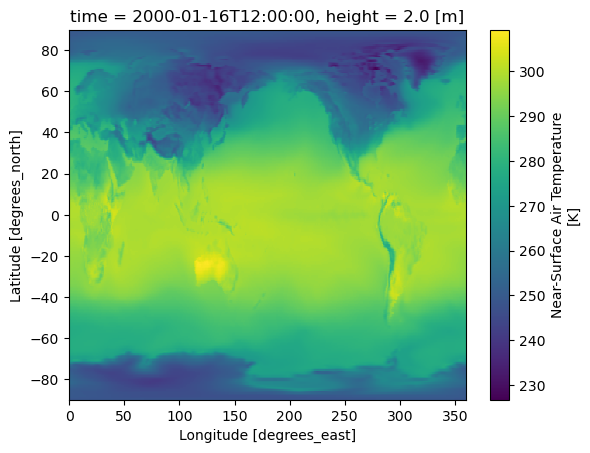

In [18]:
data.tas.isel(time=0).plot()

We instantiate the `Regridder` class defining the source grid, the target grid and the interpolation method. For the source grid we use a sample of the data themselves. For the target grid we express it with a string "r180x90" in CDO style and the method is one understood by CDO ("ycon"). This could also be a path to a sample file.

In [12]:
sgrid = data.tas.isel(time=0)
regridder = Regridder(source_grid=sgrid, target_grid="r180x90", method="ycon")

The weights have been computed and stored in the class (`regridder.weights`).
We can now regrid our data

In [14]:
datar = regridder.regrid(data)

the result is a 180x90 array at 2° resolution:

In [15]:
datar.tas 

<xarray.DataArray 'tas' (time: 12, lat: 90, lon: 180)>
dask.array<reshape, shape=(12, 90, 180), dtype=float64, chunksize=(12, 90, 180), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2000-01-16T12:00:00 ... 2000-12-16T12:00:00
    height   float64 2.0
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
Attributes:
    standard_name:     air_temperature
    long_name:         Near-Surface Air Temperature
    units:             K
    CDI_grid_type:     gaussian
    CDI_grid_num_LPE:  128
    comment:           near-surface (usually, 2 meter) air temperature
    cell_methods:      area: time: mean
    cell_measures:     area: areacella
    history:           2019-09-26T07:00:39Z altered by CMOR: Treated scalar d...

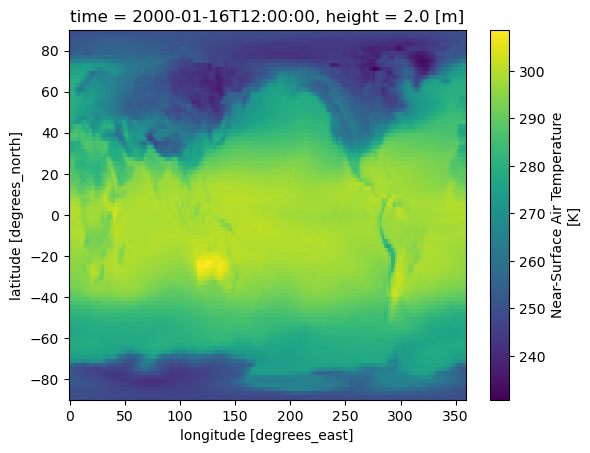

In [19]:
datar.tas.isel(time=0).plot()

The `regridder` method can be applied both to a Dataset or a Dataarray.

We could also use the method `cdo_generate_weights` to generate weights separately and maybe store them for future use:

In [16]:
weights = cdo_generate_weights(sgrid, target_grid="r180x90", method="ycon")

and then use them directly for regridding

In [17]:
regridder2 = Regridder(weights=weights)
datar2 = regridder.regrid(data)
datar2

<xarray.Dataset>
Dimensions:    (time: 12, bnds: 2, lat: 90, lon: 180)
Coordinates:
  * time       (time) datetime64[ns] 2000-01-16T12:00:00 ... 2000-12-16T12:00:00
    height     float64 2.0
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon        (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(12, 2), meta=np.ndarray>
    tas        (time, lat, lon) float64 dask.array<chunksize=(12, 90, 180), meta=np.ndarray>
Attributes: (12/49)
    CDI:                    Climate Data Interface version 2.0.4 (https://mpi...
    source:                 EC-Earth3 (2019): \naerosol: none\natmos: IFS cy3...
    institution:            AEMET, Spain; BSC, Spain; CNR-ISAC, Italy; DMI, D...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    ...                     ...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/993a2173-51e8-4df6-baf0-60a1c8d4a62d
    branch_time_in_child:   0.0D
    branch_time_in_parent:  149749.0D
    history:                Mon Jan 30 11:36:06 2023: cdo -f nc4 -z zip copy ...
    CDO:                    Climate Data Operators version 2.0.4 (https://mpi...